#### Libraries Needed
- pandas, geopandas, plotly, dash
  - install the missing library through : `pip3 install library`
  - **The plots and interactive world maps generated using plotly and geopandas will not display if you dont have them**
  - *I would recommend installing the plotly libraries, as the interactive maps are quite fun once you can display them. They display properties such as names, and sizes upon hovering, and you can zoom into the world maps as well.* 
#### Data
- The data used is obtained from UNESCO for the purposes of the WiTH Africa data challenge as an xls file. 

In [1]:
import pandas as pd
import plotly as px
import geopandas as gp

/opt/homebrew/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_23646/1208084224.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.rea

In [2]:
data_df = pd.read_excel(r'/Users/dhruvpandit/Documents/GitHub/Projects/WiTH_Africa_Data_Challenge/whc-sites-2021.xls')

### Data Modification
1. We drop all the columns with french text, as well as refine our search to only countries in Africa. 
2. We drop redundant columns, and only keep those that we might find interesting for the purposes of our EDA. 
3. We also create dummy columns for the categories. 

In [3]:
data_df.drop(data_df.loc[:, data_df.columns.str.endswith('_fr')].columns, axis=1, inplace=True)
data_df = data_df[data_df['region_en'] == 'Africa']
data_df_transformed = data_df[['rev_bis', 'name_en', 'short_description_en',
       'justification_en', 'date_inscribed', 'secondary_dates', 'danger',
       'date_end', 'danger_list', 'longitude', 'latitude', 'area_hectares',
       'category', 'category_short', 'states_name_en']]
data_df_transformed = pd.concat([data_df_transformed, pd.get_dummies(data_df_transformed['category'])], axis = 1)
data_df_transformed.loc[data_df_transformed['area_hectares']==0, 'area_hectares'] = 1

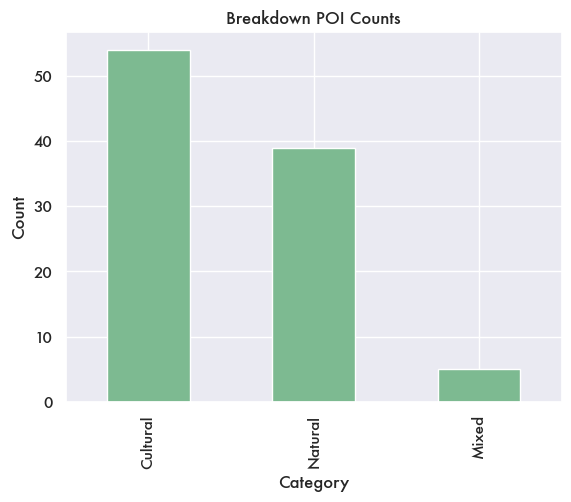

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style='darkgrid',font = 'Futura')
sns.set_palette("crest")
ax = data_df_transformed['category'].value_counts().plot(kind='bar')
ax.set(title='Breakdown POI Counts', xlabel='Category', ylabel='Count')
plt.show()


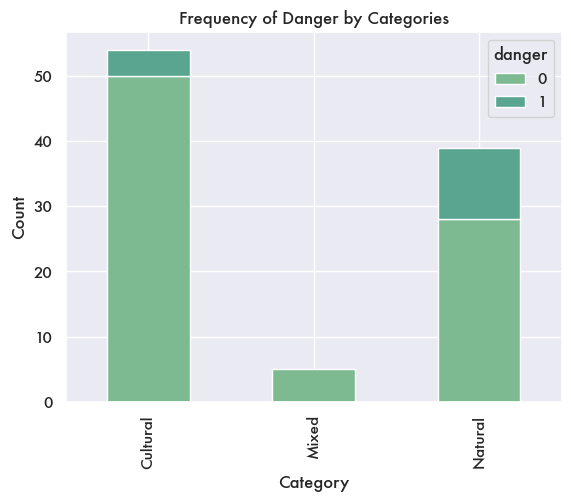

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

df = data_df_transformed.groupby(['category', 'danger'])['states_name_en'].count().unstack()

sns.set(style='darkgrid',font = 'Futura')
sns.set_palette("crest")
ax = df.plot(kind='bar', stacked=True)
ax.set(title='Frequency of Danger by Categories', xlabel='Category', ylabel='Count')
plt.show()


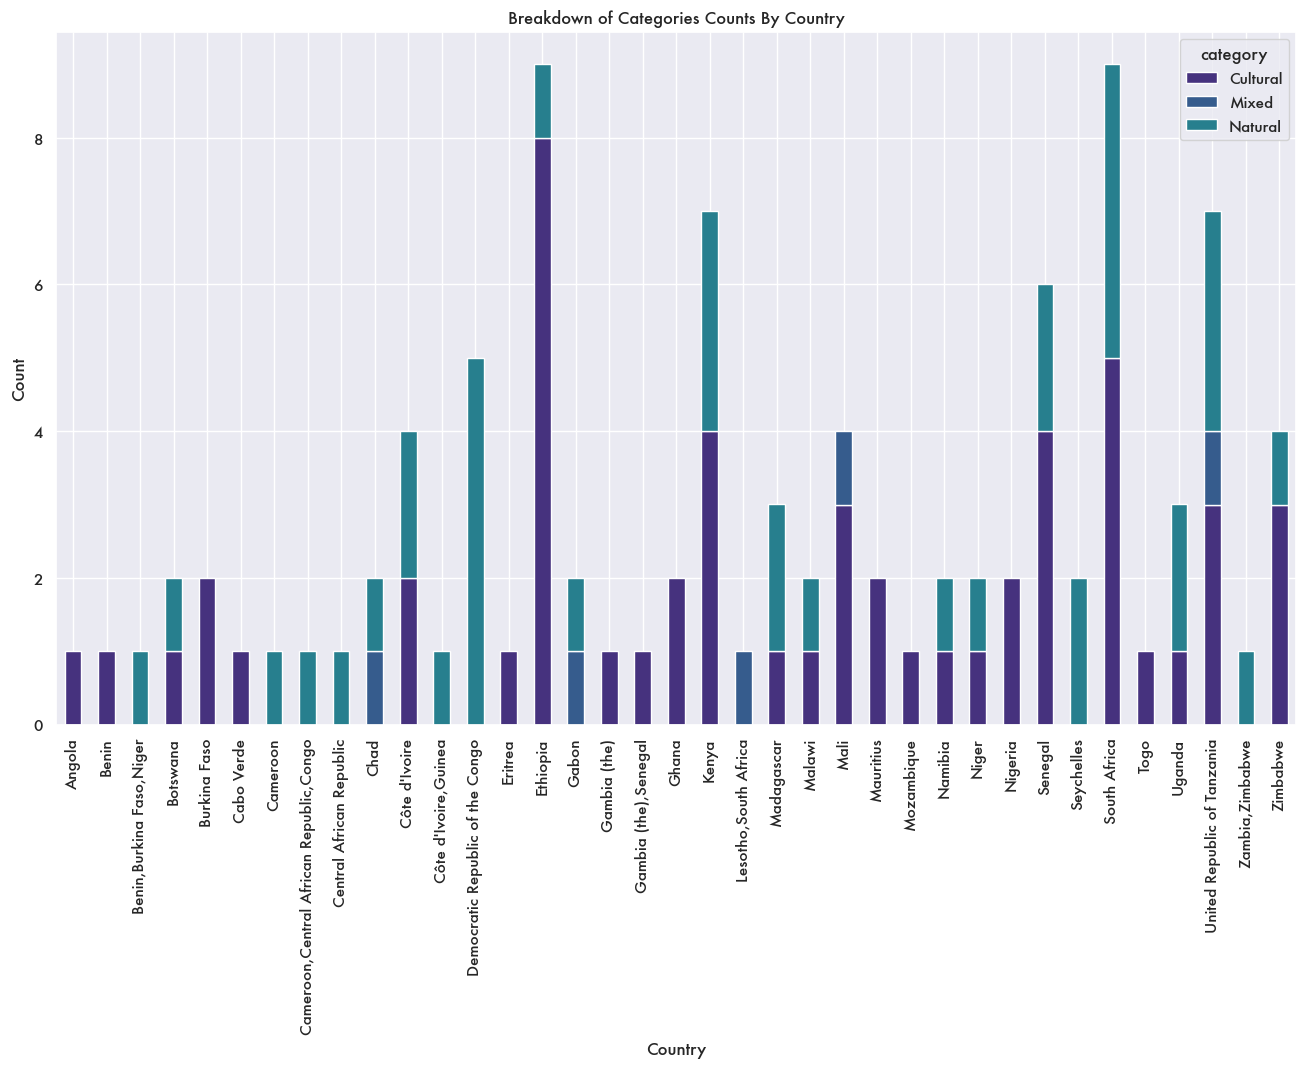

In [6]:
import seaborn as sns

df = data_df_transformed.groupby(['states_name_en', 'category'])['states_name_en'].count().unstack()
sns.set(rc={'figure.facecolor':'white', 'figure.figsize':(16,9)})
sns.set(style='darkgrid',font = 'Futura')
sns.set_palette("viridis")

ax = df.plot(kind='bar', stacked=True)
ax.set(title='Breakdown of Categories Counts By Country', xlabel='Country', ylabel='Count')

plt.show()


### POI Locations In Africa
- This is an interactive geopandas plot that shows the locations of each POI on a world map. 

In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# create a pandas dataframe with latitude and longitude columns
df = data_df_transformed
# create a list of Point objects from the latitude and longitude columns
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]

# create a geodataframe from the dataframe and the geometry list
gdf2 = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# print the resulting geodataframe
gdf2.explore(column='category', cmap='Set1',  legend=True)

### Where are the POI located, and what is their comparative size?
- Here we have an interactive map of the places of interest. 
- Each POI is color coded according to the category it falls under. 
  - Further, the size of the POI, given by the area_hectares column is visually demonstrated through the radius of the circle. 

In [8]:
import plotly.express as px
# create an interactive world map using Plotly
fig = px.scatter_mapbox(data_df_transformed, lat='latitude', lon='longitude', hover_name='name_en', size='area_hectares', size_max=25,
                        zoom=1,  color='category', color_discrete_sequence=px.colors.qualitative.Pastel,
                        hover_data={'area_hectares': True}, width=950)

# update the mapbox style to 'open-street-map'
fig.update_layout(mapbox_style='carto-positron', margin = {"t":45, "b":25, "l":25},)
fig.update_layout(title={
    'text': "Plot Of POI in Africa With Their Size In Bubbles (Not To Scale)",
    'font': {'family': "Futura", 'size': 24},
    'x': 0.5,
    'y': 0.97,
    'xanchor': 'center',
    'yanchor': 'top'
})

fig.update_layout(
    legend=dict(
        title=dict(text='Categories', font=dict(family='Futura', size=20, color='Gray')),
        font=dict(family='Futura', size=16, color='Gray')
    )
)

fig.update_traces(marker_sizemin=3)
# show the map
fig.show(renderer = 'notebook_connected')

#### Output Static Image (if you do not have the libraries installed)
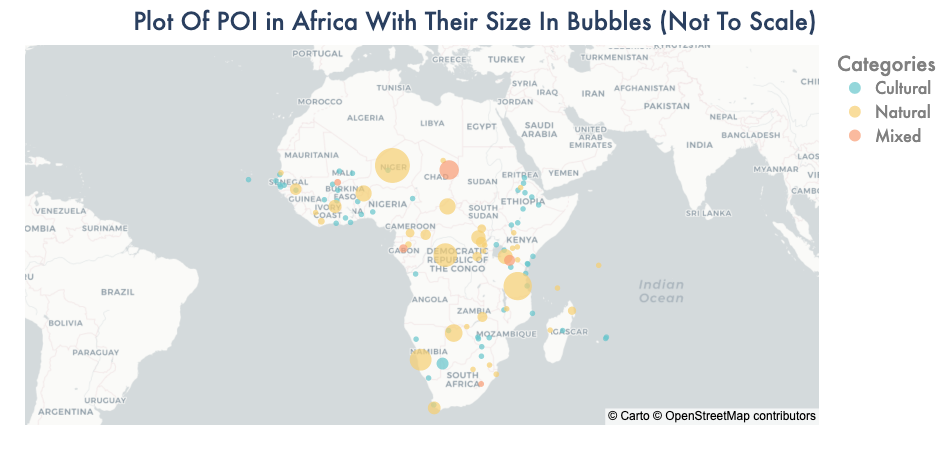

In [9]:
# create new dataframe to group the count of categories for each country
agg_df = data_df_transformed.groupby(['states_name_en', 'category']).size().unstack(fill_value=0)

In [10]:

fig = px.choropleth(agg_df, locations=agg_df.index, locationmode='country names', color='Cultural'
                    , scope='africa'
                    )
fig.update_layout(margin = {"t":45, "b":25, "l":25},)

fig.update_layout(
    font_family='Futura',
    title={
        'text': 'Number Of Cultural POIs Per Country',
        'font': {
            'size': 24,
            'color': 'Black'
        },
        'x': 0.5,
        'xanchor': 'center'
    }
)


fig.show(renderer = 'notebook_connected')

#### Output Static Image (if you do not have the libraries installed)
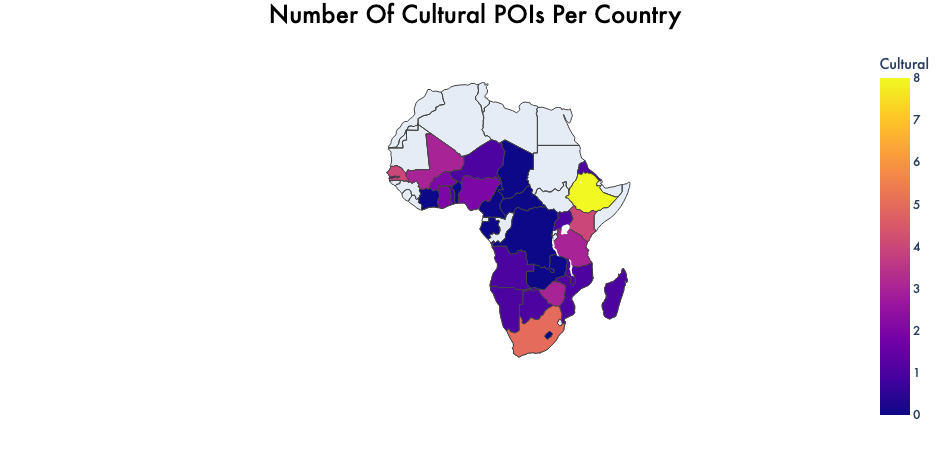

In [11]:

fig = px.choropleth(agg_df, locations=agg_df.index, locationmode='country names', color='Natural'
                    , scope='africa'
                    )
fig.update_layout(margin = {"t":45, "b":25, "l":25},)
fig.update_layout(
    font_family='Futura',
    title={
        'text': 'Number Of Natural POIs Per Country',
        'font': {
            'size': 24,
            'color': 'Black'
        },
        'x': 0.5,
        'xanchor': 'center'
    }
)


fig.show(renderer = 'notebook_connected')

#### Output Static Image (if you do not have the libraries installed)
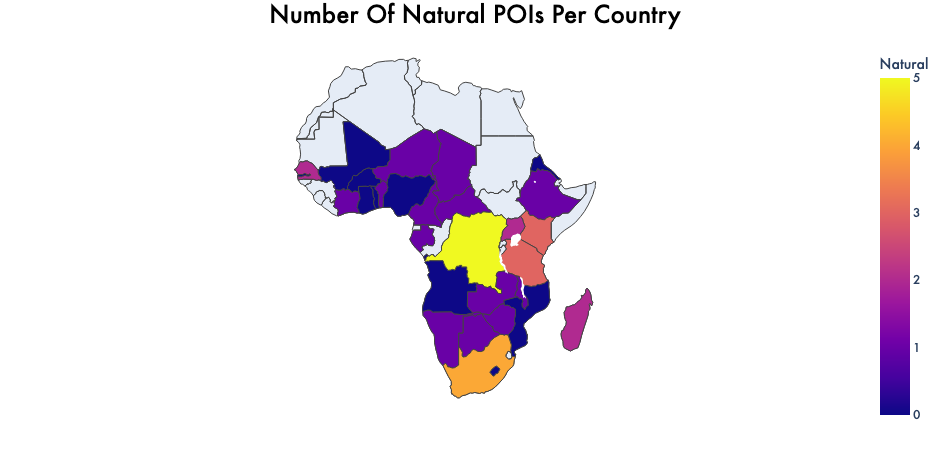

In [12]:

fig = px.choropleth(agg_df, locations=agg_df.index, locationmode='country names', color='Mixed'
                    , scope='africa'
                    )
fig.update_layout(margin = {"t":45, "b":25, "l":25},)
fig.update_layout(
    font_family='Futura',
    title={
        'text': 'Number Of Mixed POIs Per Country',
        'font': {
            'size': 24,
            'color': 'Black'
        },
        'x': 0.5,
        'xanchor': 'center'
    }
)


fig.show(renderer = 'notebook_connected')

#### Output Static Image (if you do not have the libraries installed)
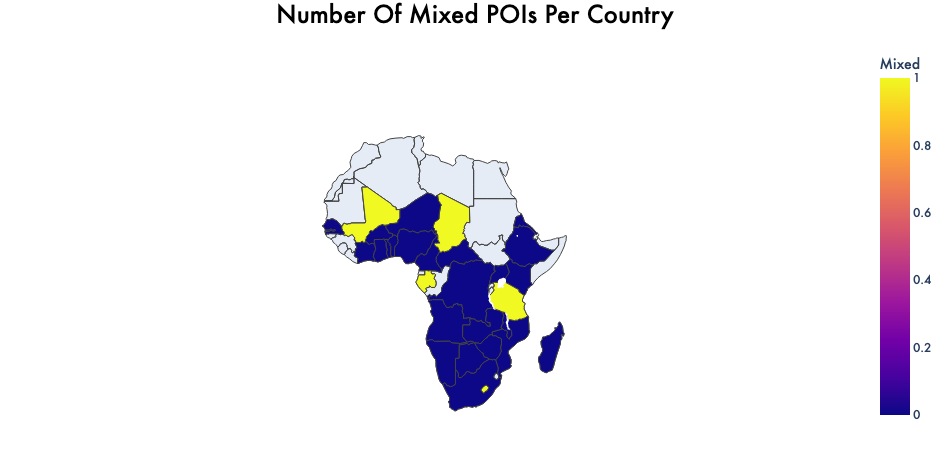

In [16]:
data_df_transformed['danger'] = data_df_transformed['danger'].astype(str)

In [17]:

fig = px.choropleth(data_df_transformed, locations='states_name_en', locationmode='country names', color='danger'
                    , scope='africa'
                    )
fig.update_layout(margin = {"t":45, "b":25, "l":25},)
fig.update_layout(
    font_family='Futura',
    title={
        'text': 'Level Of Danger',
        'font': {
            'size': 24,
            'color': 'Black'
        },
        'x': 0.5,
        'xanchor': 'center'
    }
)


fig.show(renderer = 'notebook_connected')

#### Output Static Image (if you do not have the libraries installed)
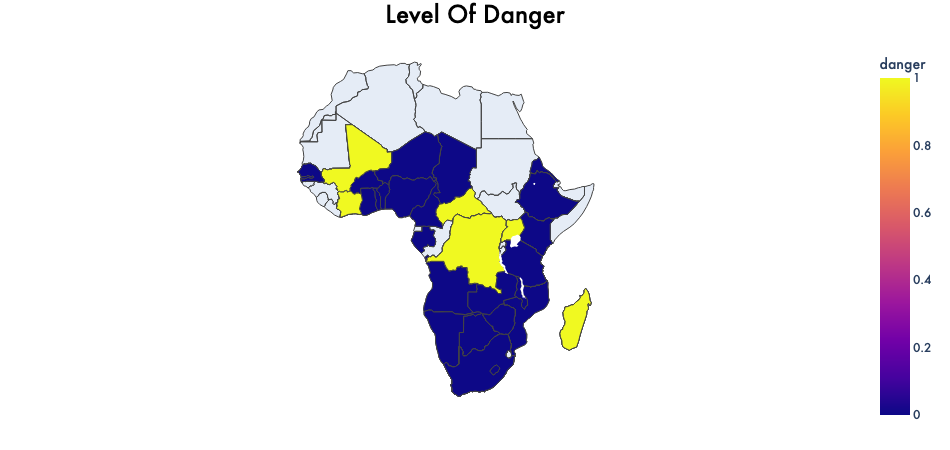

### Visual Breakdown of the POI Categories by Country

In [24]:
# create the density heatmap chart
fig = px.density_heatmap(data_df_transformed, x="category", y="states_name_en", height=1000)

# update the font of all items in the layout
fig.update_layout(
    font_family='Futura',
    title={
        'text': 'Density Heatmap',
        'font': {
            'size': 24,
            'color': 'Black'
        },
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Category',
    yaxis_title='Country'
)


# display the chart
fig.show(renderer = 'notebook_connected')

#### Output Static Image (if you do not have the libraries installed)
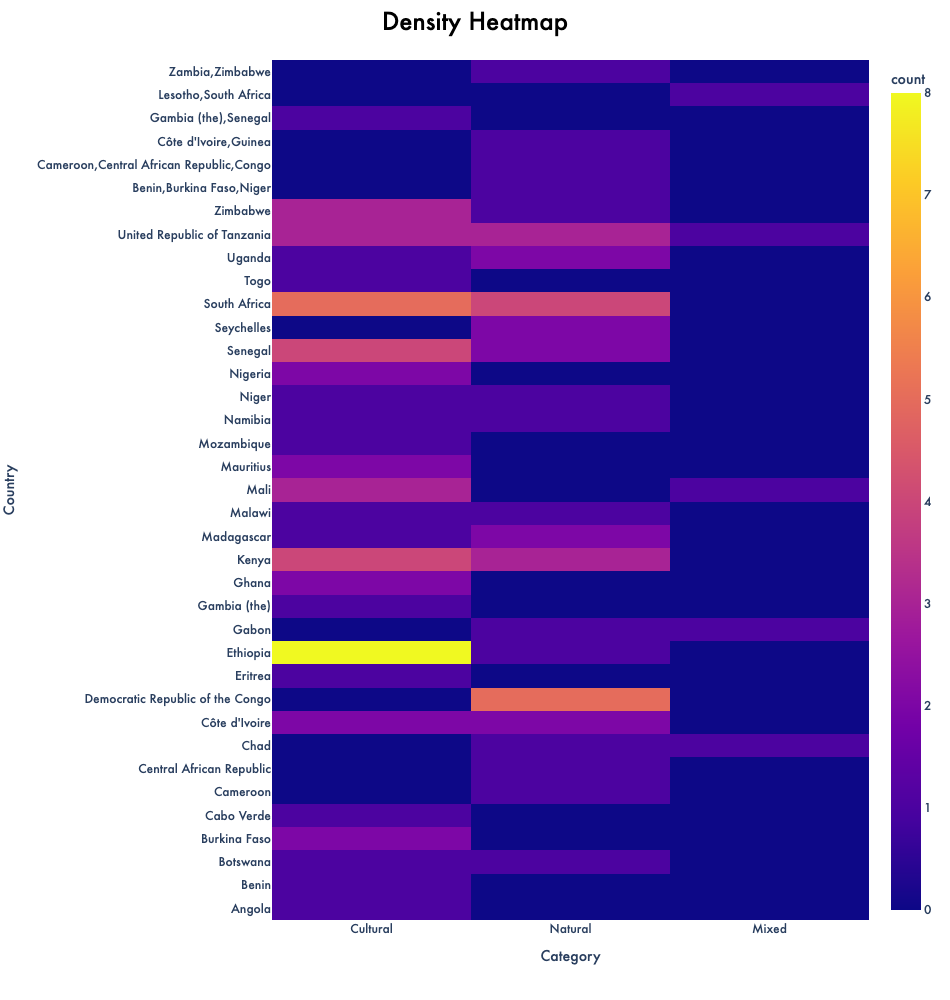